In [13]:
printmd('Self designed PYTORCH Multi class Image Classifier ')
printmd('Used limited number of 4 different types of animals - Cats, Dogs, Horses and Zebras.')
printmd("As limited number of Images used, couldn't achieve accuracy beyond 86%")
printmd('Classification reports, Confusion Matrix and Roc curves with AUC values plotted')
printmd('Accuracy and Loss plots comparing training and validation performance.')


## <span style="color:red">Self designed PYTORCH Multi class Image Classifier </span>

## <span style="color:red">Used limited number of 4 different types of animals - Cats, Dogs, Horses and Zebras.</span>

## <span style="color:red">As limited number of Images used, couldn't achieve accuracy beyond 86%</span>

## <span style="color:red">Classification reports, Confusion Matrix and Roc curves with AUC values plotted</span>

## <span style="color:red">Accuracy and Loss plots comparing training and validation performance.</span>

In [2]:
################################################################################################################################
# Import the required libraries
################################################################################################################################
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
import seaborn as sns
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt
from __future__ import print_function, division
import numpy as np
import torchvision
from torchvision import models, transforms, datasets
import time
import os
import copy

import tqdm
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown('## <span style="color:red">'+string+'</span>'))

['cats', 'dogs', 'horses', 'zebras']


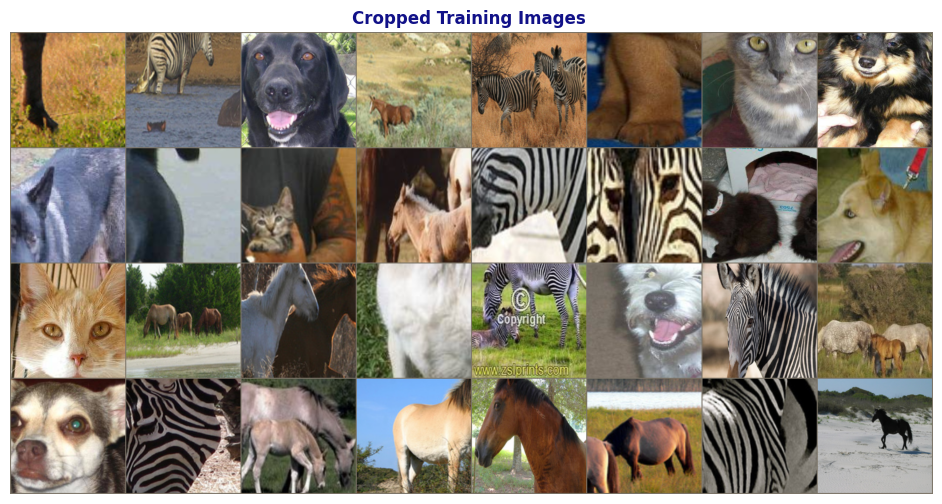

In [4]:
################################################################################################################################
# define separate transformations for training and validation
# Data augmentation and normalization for training
# Just normalization for validation
################################################################################################################################

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(256),   
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        
    ]),
    'val': transforms.Compose([
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    
    ]),
}

################################################################################################################################
# define data path, dataset and dataloaders
################################################################################################################################

data_dir = './dataset'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders={x: torch.utils.data.DataLoader(image_datasets[x],batch_size=8,shuffle=True,num_workers=0) for x in ['train','val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
print(class_names)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

################################################################################################################################
# define plotting function to Visualize few training images so as to understand the data augmentations.
################################################################################################################################

def imshow(inp, title=None):
    """Imshow for Tensor."""
    plt.figure(figsize=(16,6))
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.axis('off')
    if title is not None:
        plt.title(title,fontweight='bold',color='#111188',fontsize=12)
    plt.pause(0.001)  # pause a bit so that plots are updated
################################################################################################################################
# define the viz function to accept and plot number of row images
################################################################################################################################

def viz(num_img_rows=1):
    # Get a few batchs of training data
    input_list=[]
    trans = torchvision.transforms.Compose([torchvision.transforms.Resize((224,224))])
    for i in range(num_img_rows):
        inputs, classes = next(iter(dataloaders['train']))
        for j in range(dataloaders['train'].batch_size):
            image = inputs[j].float()
            image = trans(image)
            #image=torch.tensor(image)
            input_list.append(image)
    # Make a grid from batch.
    out = torchvision.utils.make_grid(input_list)

    #imshow(out, title=[class_names[x].center(22) for x in classes])
    imshow(out, title='Cropped Training Images ')

viz(num_img_rows=4)

In [5]:
################################################################################################################################
# define the training module which performs the training and validations and also save the module on increase in val_accuracy
################################################################################################################################

def train_model(model, criterion, optimizer, scheduler, num_epochs=25,best_acc=0):
    since = time.time()
    TrainLoss = []
    TrainAcc = []
    ValLoss = []
    ValAcc = []

    from tqdm.notebook import tqdm as tqdmTrain
    best_model_wts = copy.deepcopy(model.state_dict())
    print('best_acc ',best_acc)
    for epoch in tqdmTrain(range(num_epochs)):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 125)
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            running_loss = 0.0
            running_corrects = 0
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    a, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    ##########################################################################
                    # l1 & l2 regularization
                    #l12_lambda = 1e-7
                    #l1_norm = sum(p.abs().sum()    for p in model.parameters())
                    #l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
                    #loss = loss + l12_lambda * l1_norm
                    #loss = loss + l12_lambda * l2_norm
                    ##########################################################################
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if phase == 'train':
                scheduler.step()
                TrainLoss.append(epoch_loss)
                TrainAcc.append(epoch_acc)
            if phase == 'val':
                ValLoss.append(epoch_loss)
                ValAcc.append(epoch_acc)
            print('{} | Loss: {:.4f} | Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                #torch.save(model.state_dict(), './Weights/model_PYTORCH_CNN_PET_4CLASSES_83%.pth')
                torch.save(model.state_dict(), './Weights/model_PYTORCH_CNN_PET_4CLASSES_Functional.pth')
                print(' ')
                print('Val Accuracy improved from ', best_acc , ' to ', epoch_acc, ' ', time.ctime() )
                print(' ')
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model,[TrainAcc,TrainLoss,ValAcc,ValLoss]

In [6]:
################################################################################################################################
# define the neural netwrok module in sequential and functional way
################################################################################################################################

class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)
def preprocess(x):
    return x.view(-1, 3, 224, 224)

################################################################################################################################
################### sequential module ##########################################################################################
################################################################################################################################

#this is for 80.50% accuracy model and size 224 x 224
def model_create():
    model = nn.Sequential(
        Lambda(preprocess),
        nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
        nn.ReLU(),
        nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
        nn.ReLU(),
        nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
        nn.ReLU(),
        nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
        nn.ReLU(),
        nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
        nn.ReLU(),
        nn.Conv2d(256, 4, kernel_size=3, stride=2, padding=1),
        nn.ReLU(),
        #nn.AvgPool2d(4),
        nn.MaxPool2d(4),
        Lambda(lambda x: x.view(x.size(0), -1)),
    )
    return model

################################################################################################################################
################### Functional module ##########################################################################################
################################################################################################################################

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3,stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3,stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3,stride=2, padding=1)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3,stride=2, padding=1)
        self.conv5 = nn.Conv2d(128, 128, kernel_size=3,stride=2, padding=1)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3,stride=2, padding=1)
        self.conv6_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(512, 32)
        self.fc2 = nn.Linear(32, 4)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = F.relu(F.max_pool2d(self.conv6_drop(self.conv6(x)), 2))
    
        #print(x.shape)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)



In [7]:
################################################################################################################################
# instatiate either sequential or functional network
################################################################################################################################
#model = model_create()
model = Net()

In [8]:
################################################################################################################################
# print the model
################################################################################################################################
print(model)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv5): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv6): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv6_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=512, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=4, bias=True)
)


In [103]:
################################################################################################################################
# define loss criteria, optimizer, lr scheduler, learning rate, l2 norm, betas, best accuracy to comapre and number of epochs
################################################################################################################################
criterion = nn.CrossEntropyLoss()   
epochs = 350

optimizer = optim.Adam(model.parameters(), lr=4.1583e-04,weight_decay=8e-5,amsgrad=False,betas=(.9,.999)) 
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.90,last_epoch=-1,verbose=True)

model,stat = train_model(model, criterion, optimizer, step_lr_scheduler,epochs,best_acc=0.860)

Adjusting learning rate of group 0 to 4.1583e-04.
best_acc  0.86


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 0/349
-----------------------------------------------------------------------------------------------------------------------------
Adjusting learning rate of group 0 to 4.1583e-04.
train | Loss: 0.3928 | Acc: 0.8530
val | Loss: 0.5590 | Acc: 0.8200

Epoch 1/349
-----------------------------------------------------------------------------------------------------------------------------
Adjusting learning rate of group 0 to 4.1583e-04.
train | Loss: 0.4256 | Acc: 0.8420
val | Loss: 0.7124 | Acc: 0.8000

Epoch 2/349
-----------------------------------------------------------------------------------------------------------------------------
Adjusting learning rate of group 0 to 4.1583e-04.
train | Loss: 0.4520 | Acc: 0.8250
val | Loss: 0.6205 | Acc: 0.7950

Epoch 3/349
-----------------------------------------------------------------------------------------------------------------------------
Adjusting learning rate of group 0 to 4.1583e-04.
train | Loss: 0.4158 | Acc: 0.8430
val | 

val | Loss: 0.7902 | Acc: 0.7500

Epoch 32/349
-----------------------------------------------------------------------------------------------------------------------------
Adjusting learning rate of group 0 to 2.2099e-04.
train | Loss: 0.3776 | Acc: 0.8650
val | Loss: 0.5791 | Acc: 0.8000

Epoch 33/349
-----------------------------------------------------------------------------------------------------------------------------
Adjusting learning rate of group 0 to 2.2099e-04.
train | Loss: 0.3589 | Acc: 0.8710
val | Loss: 0.5927 | Acc: 0.8300

Epoch 34/349
-----------------------------------------------------------------------------------------------------------------------------
Adjusting learning rate of group 0 to 1.9889e-04.
train | Loss: 0.3547 | Acc: 0.8680
val | Loss: 0.5340 | Acc: 0.8050

Epoch 35/349
-----------------------------------------------------------------------------------------------------------------------------
Adjusting learning rate of group 0 to 1.9889e-04.
tra

val | Loss: 0.6550 | Acc: 0.8250

Epoch 64/349
-----------------------------------------------------------------------------------------------------------------------------
Adjusting learning rate of group 0 to 1.0570e-04.
train | Loss: 0.3487 | Acc: 0.8690
val | Loss: 0.7347 | Acc: 0.8100

Epoch 65/349
-----------------------------------------------------------------------------------------------------------------------------
Adjusting learning rate of group 0 to 1.0570e-04.
train | Loss: 0.2858 | Acc: 0.8910
val | Loss: 0.7847 | Acc: 0.8050

Epoch 66/349
-----------------------------------------------------------------------------------------------------------------------------
Adjusting learning rate of group 0 to 1.0570e-04.
train | Loss: 0.3701 | Acc: 0.8680
val | Loss: 0.6333 | Acc: 0.8250

Epoch 67/349
-----------------------------------------------------------------------------------------------------------------------------
Adjusting learning rate of group 0 to 1.0570e-04.
tra

val | Loss: 0.7386 | Acc: 0.8100

Epoch 96/349
-----------------------------------------------------------------------------------------------------------------------------
Adjusting learning rate of group 0 to 5.6172e-05.
train | Loss: 0.3067 | Acc: 0.8960
val | Loss: 0.7300 | Acc: 0.8350

Epoch 97/349
-----------------------------------------------------------------------------------------------------------------------------
Adjusting learning rate of group 0 to 5.6172e-05.
train | Loss: 0.2822 | Acc: 0.9000
val | Loss: 0.6988 | Acc: 0.8400

Epoch 98/349
-----------------------------------------------------------------------------------------------------------------------------
Adjusting learning rate of group 0 to 5.6172e-05.
train | Loss: 0.2586 | Acc: 0.9050
val | Loss: 0.6884 | Acc: 0.8100

Epoch 99/349
-----------------------------------------------------------------------------------------------------------------------------
Adjusting learning rate of group 0 to 5.0555e-05.
tra

Adjusting learning rate of group 0 to 2.9852e-05.
train | Loss: 0.2733 | Acc: 0.8980
val | Loss: 0.7147 | Acc: 0.8250

Epoch 128/349
-----------------------------------------------------------------------------------------------------------------------------
Adjusting learning rate of group 0 to 2.9852e-05.
train | Loss: 0.2651 | Acc: 0.9020
val | Loss: 0.7785 | Acc: 0.8100

Epoch 129/349
-----------------------------------------------------------------------------------------------------------------------------
Adjusting learning rate of group 0 to 2.6867e-05.
train | Loss: 0.2650 | Acc: 0.9180
val | Loss: 0.7391 | Acc: 0.8350

Epoch 130/349
-----------------------------------------------------------------------------------------------------------------------------
Adjusting learning rate of group 0 to 2.6867e-05.
train | Loss: 0.3134 | Acc: 0.8940
val | Loss: 0.7042 | Acc: 0.8200

Epoch 131/349
------------------------------------------------------------------------------------------

Adjusting learning rate of group 0 to 1.4278e-05.
train | Loss: 0.2851 | Acc: 0.9120
val | Loss: 0.6982 | Acc: 0.8200

Epoch 160/349
-----------------------------------------------------------------------------------------------------------------------------
Adjusting learning rate of group 0 to 1.4278e-05.
train | Loss: 0.2929 | Acc: 0.9000
val | Loss: 0.6998 | Acc: 0.8300

Epoch 161/349
-----------------------------------------------------------------------------------------------------------------------------
Adjusting learning rate of group 0 to 1.4278e-05.
train | Loss: 0.2713 | Acc: 0.9120
val | Loss: 0.7009 | Acc: 0.8300

Epoch 162/349
-----------------------------------------------------------------------------------------------------------------------------
Adjusting learning rate of group 0 to 1.4278e-05.
train | Loss: 0.2651 | Acc: 0.9050
val | Loss: 0.7236 | Acc: 0.8350

Epoch 163/349
------------------------------------------------------------------------------------------

Adjusting learning rate of group 0 to 7.5881e-06.
train | Loss: 0.2413 | Acc: 0.9160
val | Loss: 0.7391 | Acc: 0.8150

Epoch 192/349
-----------------------------------------------------------------------------------------------------------------------------
Adjusting learning rate of group 0 to 7.5881e-06.
train | Loss: 0.2248 | Acc: 0.9090
val | Loss: 0.7434 | Acc: 0.8200

Epoch 193/349
-----------------------------------------------------------------------------------------------------------------------------
Adjusting learning rate of group 0 to 7.5881e-06.
train | Loss: 0.2563 | Acc: 0.9230
val | Loss: 0.7374 | Acc: 0.8300

Epoch 194/349
-----------------------------------------------------------------------------------------------------------------------------
Adjusting learning rate of group 0 to 6.8293e-06.
train | Loss: 0.2850 | Acc: 0.9030
val | Loss: 0.7497 | Acc: 0.8150

Epoch 195/349
------------------------------------------------------------------------------------------

Adjusting learning rate of group 0 to 4.0326e-06.
train | Loss: 0.2318 | Acc: 0.9190
val | Loss: 0.7403 | Acc: 0.8250

Epoch 224/349
-----------------------------------------------------------------------------------------------------------------------------
Adjusting learning rate of group 0 to 3.6293e-06.
train | Loss: 0.2018 | Acc: 0.9350
val | Loss: 0.7462 | Acc: 0.8250

Epoch 225/349
-----------------------------------------------------------------------------------------------------------------------------
Adjusting learning rate of group 0 to 3.6293e-06.
train | Loss: 0.2600 | Acc: 0.9140
val | Loss: 0.7442 | Acc: 0.8250

Epoch 226/349
-----------------------------------------------------------------------------------------------------------------------------
Adjusting learning rate of group 0 to 3.6293e-06.
train | Loss: 0.2629 | Acc: 0.9120
val | Loss: 0.7451 | Acc: 0.8250

Epoch 227/349
------------------------------------------------------------------------------------------

Adjusting learning rate of group 0 to 1.9288e-06.
train | Loss: 0.2327 | Acc: 0.9190
val | Loss: 0.7409 | Acc: 0.8150

Epoch 256/349
-----------------------------------------------------------------------------------------------------------------------------
Adjusting learning rate of group 0 to 1.9288e-06.
train | Loss: 0.2407 | Acc: 0.9190
val | Loss: 0.7412 | Acc: 0.8100

Epoch 257/349
-----------------------------------------------------------------------------------------------------------------------------
Adjusting learning rate of group 0 to 1.9288e-06.
train | Loss: 0.2481 | Acc: 0.9220
val | Loss: 0.7428 | Acc: 0.8150

Epoch 258/349
-----------------------------------------------------------------------------------------------------------------------------
Adjusting learning rate of group 0 to 1.9288e-06.
train | Loss: 0.2413 | Acc: 0.9310
val | Loss: 0.7445 | Acc: 0.8100

Epoch 259/349
------------------------------------------------------------------------------------------

Adjusting learning rate of group 0 to 1.0250e-06.
train | Loss: 0.2762 | Acc: 0.9110
val | Loss: 0.7355 | Acc: 0.8150

Epoch 288/349
-----------------------------------------------------------------------------------------------------------------------------
Adjusting learning rate of group 0 to 1.0250e-06.
train | Loss: 0.2606 | Acc: 0.9100
val | Loss: 0.7364 | Acc: 0.8100

Epoch 289/349
-----------------------------------------------------------------------------------------------------------------------------
Adjusting learning rate of group 0 to 9.2253e-07.
train | Loss: 0.2980 | Acc: 0.8860
val | Loss: 0.7368 | Acc: 0.8150

Epoch 290/349
-----------------------------------------------------------------------------------------------------------------------------
Adjusting learning rate of group 0 to 9.2253e-07.
train | Loss: 0.2271 | Acc: 0.9190
val | Loss: 0.7381 | Acc: 0.8200

Epoch 291/349
------------------------------------------------------------------------------------------

Adjusting learning rate of group 0 to 4.9027e-07.
train | Loss: 0.2637 | Acc: 0.9240
val | Loss: 0.7368 | Acc: 0.8200

Epoch 320/349
-----------------------------------------------------------------------------------------------------------------------------
Adjusting learning rate of group 0 to 4.9027e-07.
train | Loss: 0.2355 | Acc: 0.9220
val | Loss: 0.7370 | Acc: 0.8200

Epoch 321/349
-----------------------------------------------------------------------------------------------------------------------------
Adjusting learning rate of group 0 to 4.9027e-07.
train | Loss: 0.2525 | Acc: 0.9140
val | Loss: 0.7373 | Acc: 0.8200

Epoch 322/349
-----------------------------------------------------------------------------------------------------------------------------
Adjusting learning rate of group 0 to 4.9027e-07.
train | Loss: 0.2475 | Acc: 0.9220
val | Loss: 0.7378 | Acc: 0.8200

Epoch 323/349
------------------------------------------------------------------------------------------

In [10]:
################################################################################################################################
# instantiate the module and load the saved weights
################################################################################################################################
#model = Net()
model.load_state_dict(torch.load('./Weights/model_PYTORCH_CNN_PET_4CLASSES_Functional.pth'))


<All keys matched successfully>

In [11]:
################################################################################################################################
# define the visulalization module to plot images with predicted class.
################################################################################################################################

def visualize_model(model, num_image_rows=3):
    was_training = model.training
    model.eval()    
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            x=dataloaders['val']
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            plt.figure(figsize=(16,num_image_rows*2))
            for j in range(inputs.size()[0]):
                plt.subplot2grid((num_image_rows,x.batch_size),(i,j))
                plt.axis('off')
                plt.title('predicted: {}'.format(class_names[preds[j]]),fontsize=16)  
                inp = inputs.data[j].numpy().transpose((1, 2, 0))
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                inp = std * inp + mean
                inp = np.clip(inp, 0, 1)
                plt.imshow(inp,aspect=.6) 
            plt.tight_layout()
            plt.show()
            if i == num_image_rows-1:
                model.train(mode=was_training)
                return
         
        model.train(mode=was_training)

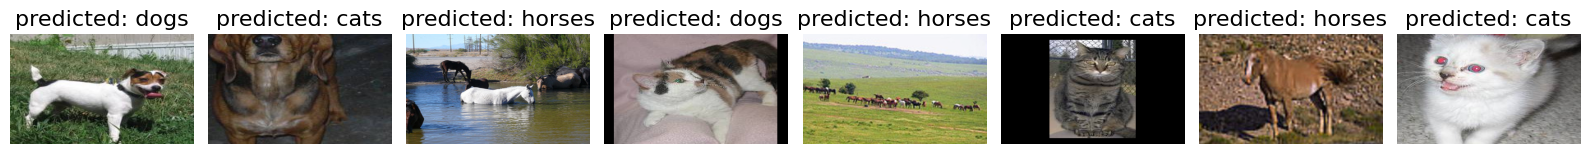

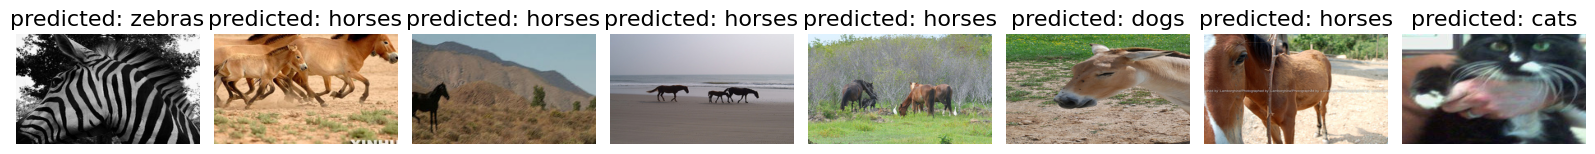

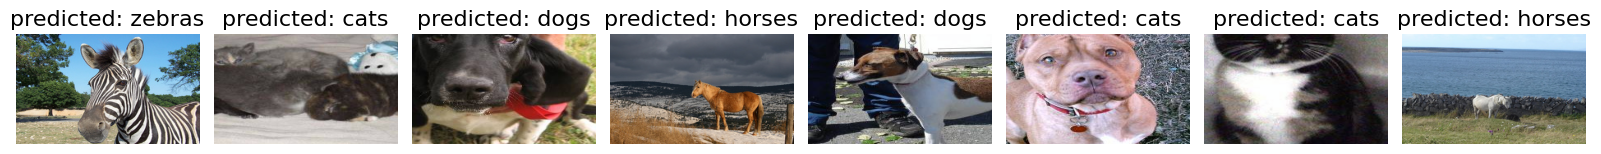

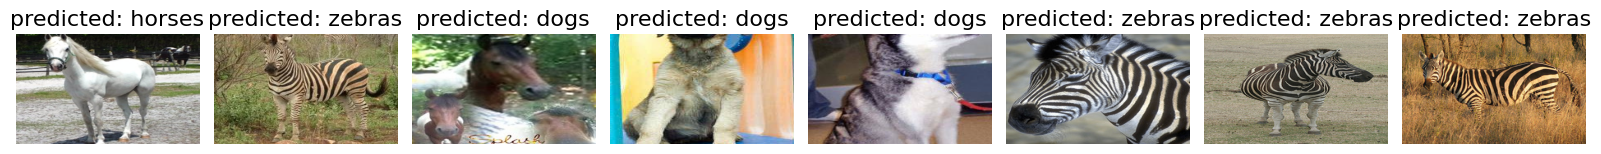

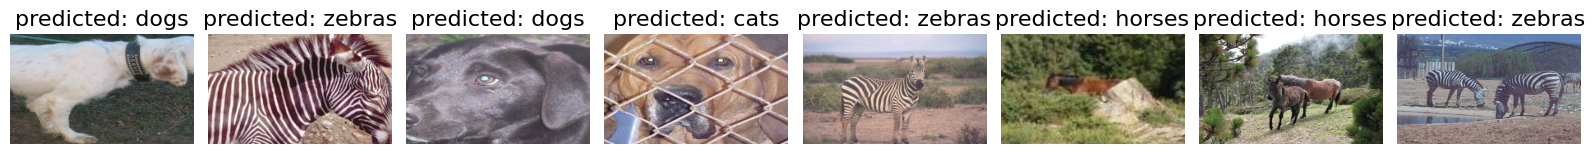

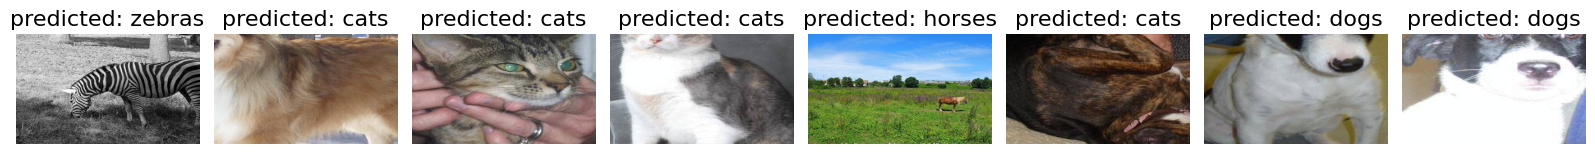

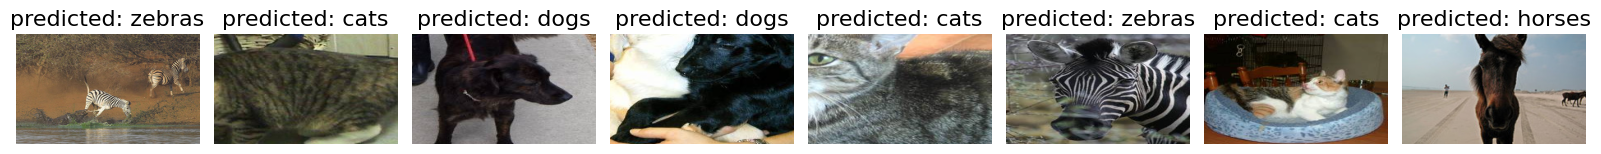

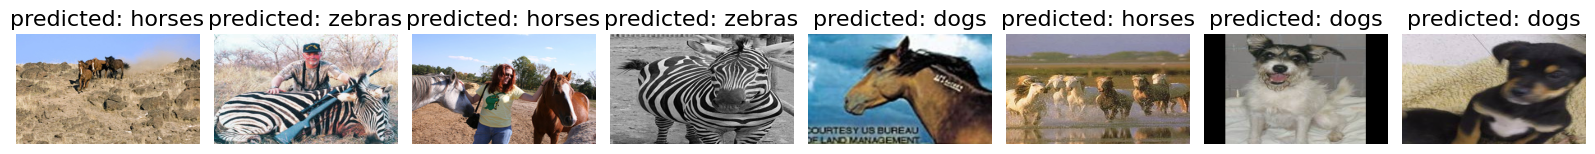

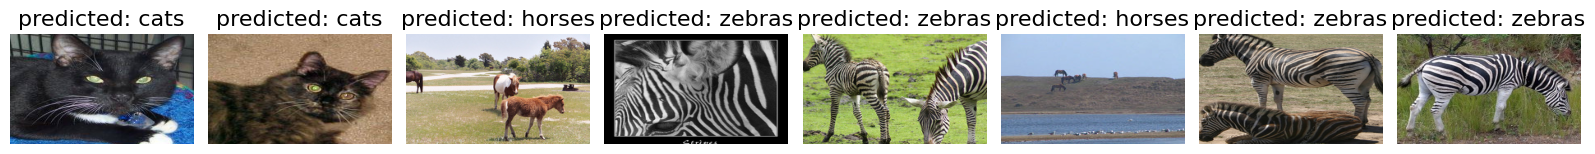

In [12]:
################################################################################################################################
# visualize few rows of images and predicted values
################################################################################################################################
visualize_model(model,num_image_rows=9)



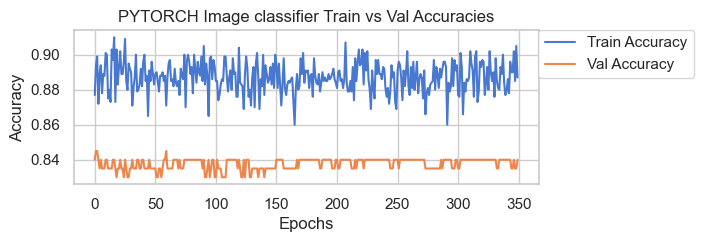

In [92]:
################################################################################################################################
# the below code is for plotting the accuracy curve of training and testing captured while training
################################################################################################################################

sns.set(style='whitegrid', palette='muted', font_scale=1.0)
plt.figure(figsize=(6,2))
plt.plot(stat[0], label='Train Accuracy')
plt.plot(stat[2], label='Val Accuracy')
plt.grid(True)
plt.title('PYTORCH Image classifier Train vs Val Accuracies')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.legend(bbox_to_anchor=(0.85, .55, 0.5, 0.5))
plt.show()

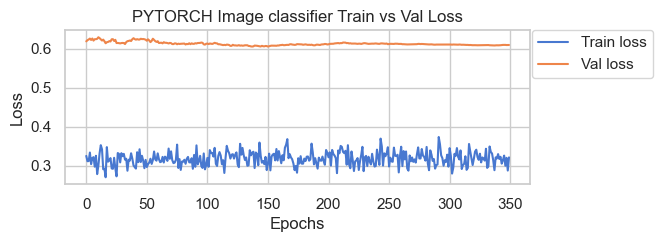

In [93]:
################################################################################################################################
# the below code is for plotting the loss curve of training and testing captured while training 
################################################################################################################################
sns.set(style='whitegrid', palette='muted', font_scale=1.0)
plt.figure(figsize=(6,2))
plt.plot(stat[1], label='Train loss')
plt.plot(stat[3], label='Val loss')
plt.title('PYTORCH Image classifier Train vs Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend(bbox_to_anchor=(0.78, .55, 0.5, 0.5))
plt.show()

In [94]:
################################################################################################################################
# predict using the model on testing data file, and compute data for confusion matix, class. report and AUC/ROC curves
################################################################################################################################
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, accuracy_score
import pandas as pd

Classes = 4
Test_Pred = []
Test_Labels = []


for i, (image, label) in enumerate(dataloaders['val']):

    outputs = model(image)
    _, scores = torch.max(outputs, 1)
    Test_Pred.extend(scores.numpy().tolist())
    Test_Labels.extend(label.numpy().tolist())
  

test_cnfu_matrix = confusion_matrix(Test_Labels, Test_Pred)
labels = ['Cats', 'Dogs', 'Horses', 'Zebras']
test_df_cm  = pd.DataFrame(test_cnfu_matrix,  index=labels, columns=labels)
print(test_df_cm)

        Cats  Dogs  Horses  Zebras
Cats      40     9       1       0
Dogs      12    36       1       1
Horses     0     3      47       0
Zebras     0     0       1      49


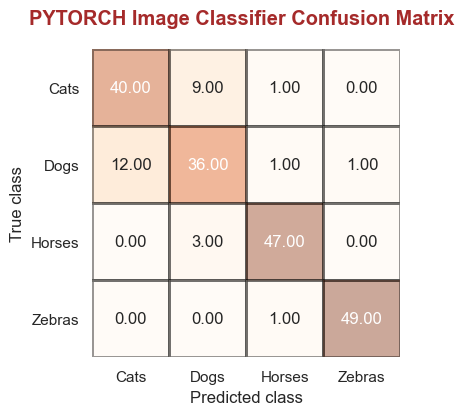

In [95]:
################################################################################################################################
# plot the confusion matrix of testing predictions and also print the traing classes counts 
################################################################################################################################

plt.figure(figsize=(4,4))
sns.set(style='whitegrid', palette='muted', font_scale=1.0)
sns.heatmap(test_df_cm,annot=True,fmt='.2f',linewidths=2,linecolor='black',square=True,cmap=plt.cm.Oranges,\
            cbar=False,alpha=.4)
plt.suptitle('PYTORCH Image Classifier Confusion Matrix',color='brown',fontweight='bold')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.xticks(rotation=0)
plt.show()  


In [96]:
################################################################################################################################
# print the classification report with precision, recall and f1-scores for all classes
################################################################################################################################
print(classification_report(Test_Labels, Test_Pred,target_names=labels))

              precision    recall  f1-score   support

        Cats       0.77      0.80      0.78        50
        Dogs       0.75      0.72      0.73        50
      Horses       0.94      0.94      0.94        50
      Zebras       0.98      0.98      0.98        50

    accuracy                           0.86       200
   macro avg       0.86      0.86      0.86       200
weighted avg       0.86      0.86      0.86       200



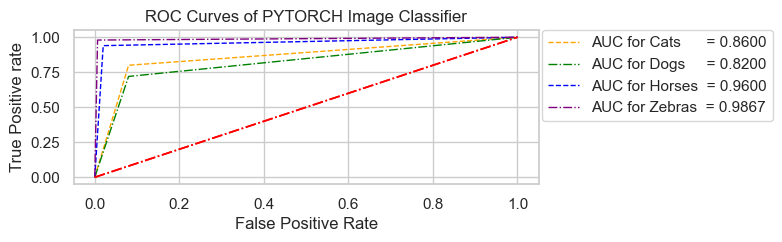

In [88]:
################################################################################################################################
# plot the roc_curve and print the AUC values in it for all the 4 classes of the model .
################################################################################################################################
sns.set(style='whitegrid', palette='muted', font_scale=1.0)
fpr = {}
tpr = {}
thresh = {}
roc_auc = {}
TestLabels = pd.get_dummies(Test_Labels)
TestPred =   pd.get_dummies(Test_Pred)
n_classes = 4
i=0
while i < n_classes:
    fpr[i], tpr[i], thresh[i] = roc_curve(TestLabels.iloc[:,i], TestPred.iloc[:,i])
    i+=1

i=0
while i < n_classes:
    roc_auc[i] = auc(fpr[i], tpr[i])
    i+=1

plt.figure(figsize=(6,2))
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange',lw=1, label='AUC for Cats      = %0.4f'% roc_auc[0])
plt.plot(fpr[1], tpr[1], linestyle='-.',color='green', lw=1, label='AUC for Dogs     = %0.4f'% roc_auc[1])
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue',  lw=1, label='AUC for Horses  = %0.4f'% roc_auc[2])
plt.plot(fpr[3], tpr[3], linestyle='-.',color='purple',lw=1, label='AUC for Zebras  = %0.4f'% roc_auc[3])
plt.plot([(0,0),(1,1)],linestyle='-.',color='red',lw=1.2)


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.title('ROC Curves of PYTORCH Image Classifier') 
plt.grid(True)
plt.legend(loc='best', bbox_to_anchor=(1.02, .55, 0.5, 0.5))
plt.show()
